<a href="https://colab.research.google.com/github/heroza/Experiment-0/blob/main/ISIC%20Dataset%20using%20ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [7]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 777M/786M [00:28<00:00, 46.5MB/s]
100% 786M/786M [00:28<00:00, 28.5MB/s]


In [8]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [9]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [20]:
df.head(3)

,FilePaths,Labels
0,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma
1,/content/Skin cancer ISIC The International Sk...,vascular lesion
2,/content/Skin cancer ISIC The International Sk...,pigmented benign keratosis


Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

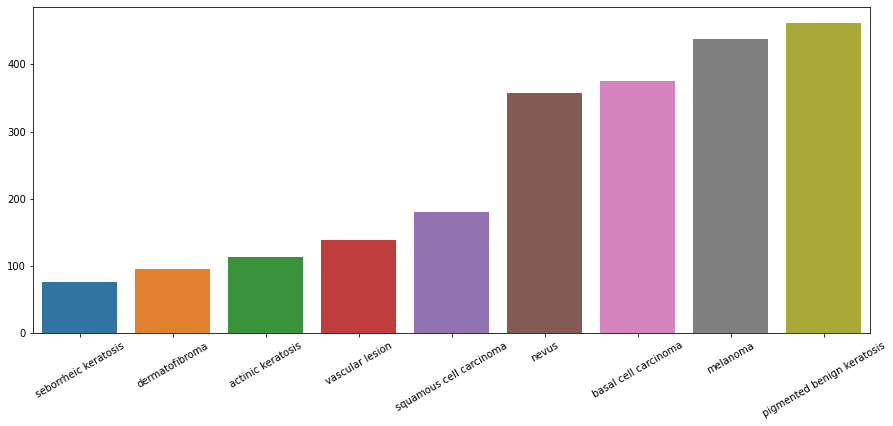

In [11]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

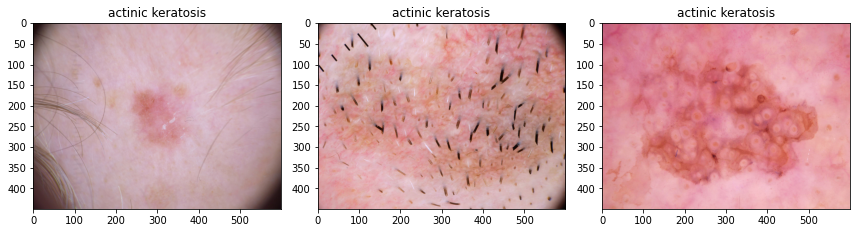

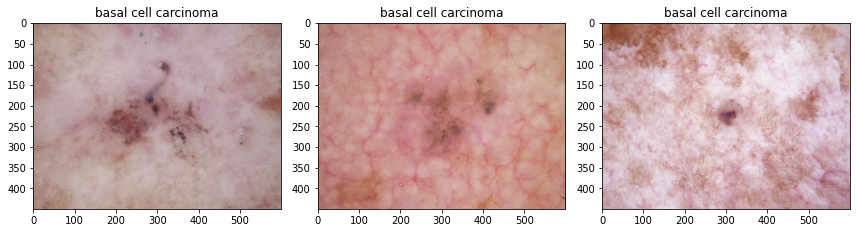

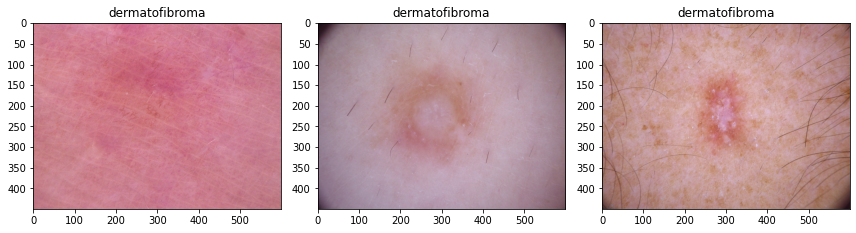

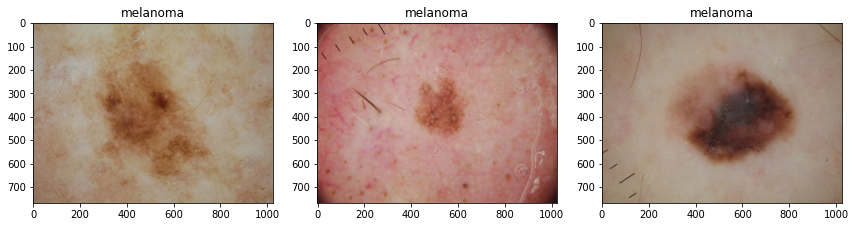

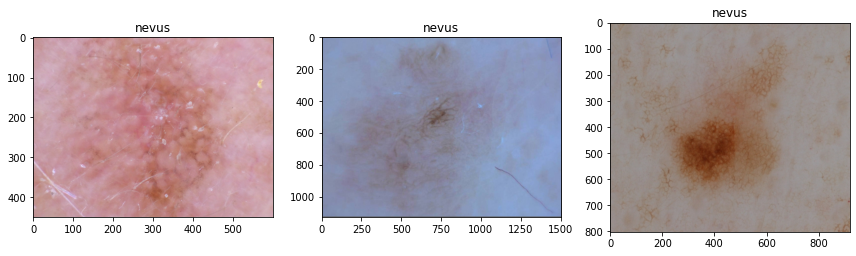

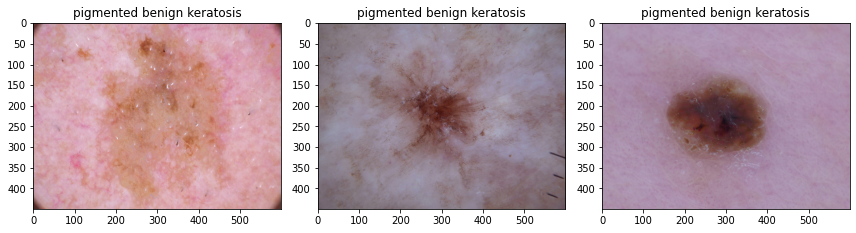

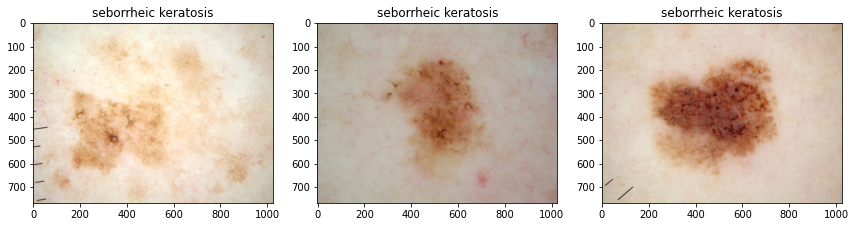

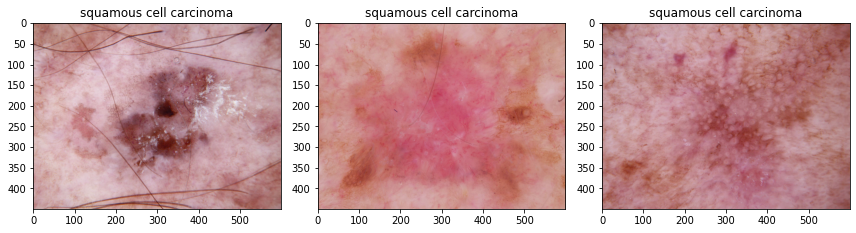

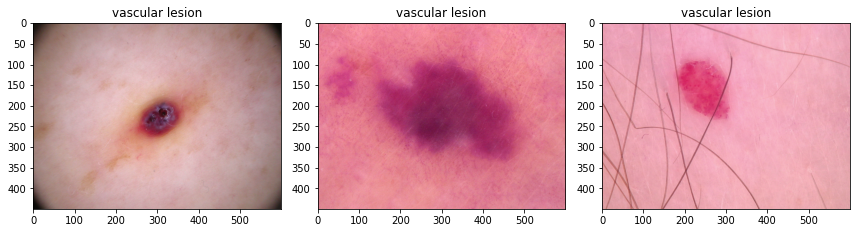

In [12]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

Split dataset to train and val

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1791, 2)
Val Data:  (448, 2)


Data Augmentation

In [15]:
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

In [16]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224, 224)

In [17]:
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

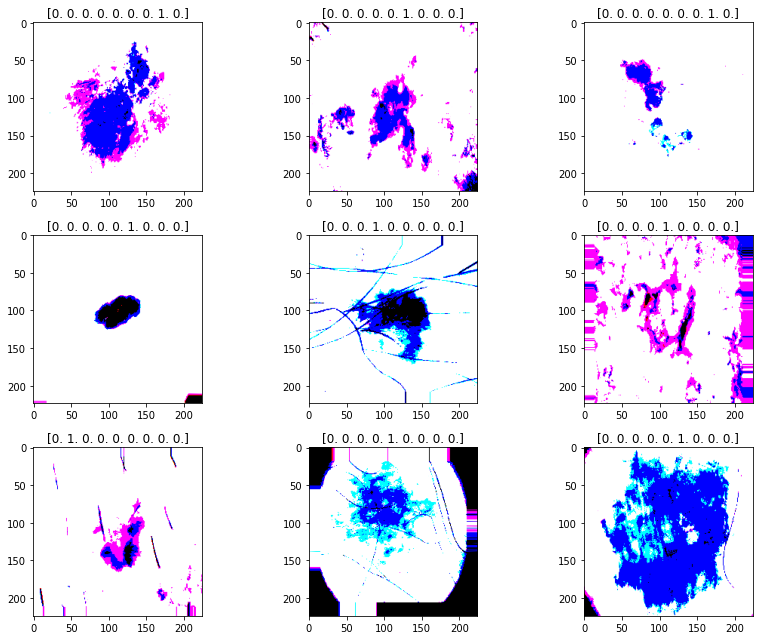

In [33]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

Create and compile the model

In [34]:
from keras.models import Sequential, load_model
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam

ResNet Architecture

Download Utility Module from github

In [35]:
!pip install requests
import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/heroza/Deep-Learning/master/resnet_keras/resnets_utils.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('resnets_utils.py', 'w') as f:
    f.write(r.text)

from resnets_utils import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [37]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [38]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [39]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [45]:
model = ResNet50(input_shape = (224, 224, 3), classes = 9)

In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model Training

In [42]:
# count of epchos
EPOCHS = 15

In [47]:
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/15
56/56 [==============================] - 70s 1s/step - loss: 5.4743 - accuracy: 0.2323 - val_loss: 17.9794 - val_accuracy: 0.1295
Epoch 2/15
56/56 [==============================] - 61s 1s/step - loss: 1.9984 - accuracy: 0.3735 - val_loss: 2.5128 - val_accuracy: 0.2411
Epoch 3/15
56/56 [==============================] - 66s 1s/step - loss: 1.6973 - accuracy: 0.4283 - val_loss: 2.0026 - val_accuracy: 0.3058
Epoch 4/15
56/56 [==============================] - 59s 1s/step - loss: 1.5272 - accuracy: 0.4712 - val_loss: 1.8264 - val_accuracy: 0.3058
Epoch 5/15
56/56 [==============================] - 60s 1s/step - loss: 1.5570 - accuracy: 0.4807 - val_loss: 1.9761 - val_accuracy: 0.2857
Epoch 6/15
56/56 [==============================] - 59s 1s/step - loss: 1.7068 - accuracy: 0.4629 - val_loss: 10.2737 - val_accuracy: 0.3214
Epoch 7/15
56/56 [==============================] - 60s 1s/step - loss: 1.4482 - accuracy: 0.4925 - val_loss: 1.9572 - val_accuracy: 0.4844
Epoch 8/15
56/56 [

Save the model

In [ ]:
#model.save_weights('model-alexnet',save_format='tf')

In [ ]:
#model.save('/content/drive/MyDrive/PHD/Model/model-alexnet')

Load the model

In [ ]:
#model = load_model('/content/drive/MyDrive/PHD/Model/model-alexnet')

In [ ]:
#model.load_weights('model')
#model.summary()

Plot the performance of val vs training set

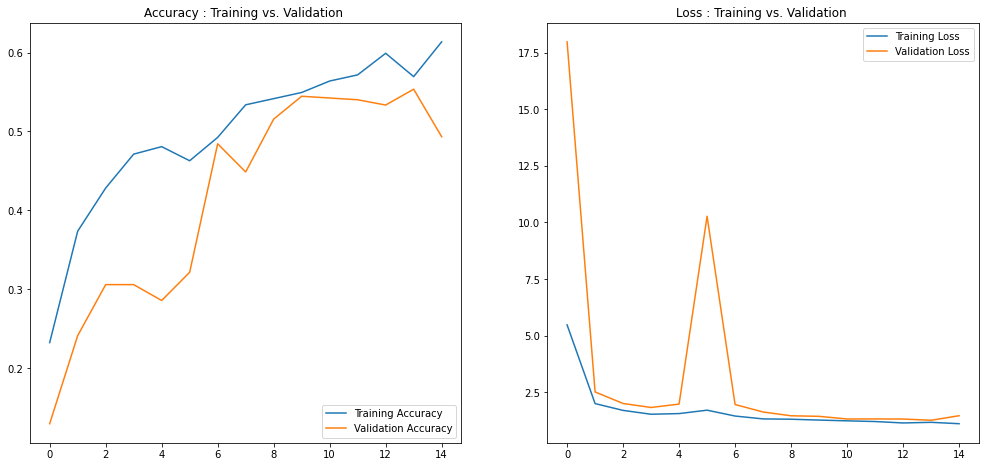

In [48]:
accuracy = hst.history['accuracy']
loss = hst.history['loss']
val_loss = hst.history['val_loss']
val_accuracy = hst.history['val_accuracy']

plt.figure(figsize=(17, 17))
plt.subplot(2, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training vs. Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Loss : Training vs. Validation ')
plt.legend(loc='upper right')
plt.show()

Load test data

In [49]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [50]:
X_test.head(3)

,FilePaths,Labels
0,Skin cancer ISIC The International Skin Imagin...,nevus
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis


In [51]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


seborrheic keratosis           3
vascular lesion                3
nevus                         16
actinic keratosis             16
pigmented benign keratosis    16
dermatofibroma                16
squamous cell carcinoma       16
melanoma                      16
basal cell carcinoma          16
Name: Labels, dtype: int64

Preprocess test image

In [52]:
# image preprocessing
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Found 118 validated image filenames belonging to 9 classes.


Evaluate model againts test data

In [53]:
res = model.evaluate(X_test)

4/4 [==============================] - 9s 2s/step - loss: 2.1493 - accuracy: 0.3220


The accuracy

In [54]:
# accuracy
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 61.36
Val Accuracy: 49.33
Test Accuracy: 32.20
Train Loss: 110.93
Val Loss: 146.22
Test Loss: 214.93


Calculate y_pred

In [55]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Y_pred (118, 9)
y_pred 118


Calculate y_true

In [56]:
# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

y_pred 118
labels 9


The confusion metric

In [57]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.ticker import FuncFormatter
import textwrap as tw

[Text(0.5, 0, 'actinic\nkeratosis'),
 Text(1.5, 0, 'basal cell\ncarcinoma'),
 Text(2.5, 0, 'dermatofib\nroma'),
 Text(3.5, 0, 'melanoma'),
 Text(4.5, 0, 'nevus'),
 Text(5.5, 0, 'pigmented\nbenign\nkeratosis'),
 Text(6.5, 0, 'seborrheic\nkeratosis'),
 Text(7.5, 0, 'squamous\ncell\ncarcinoma'),
 Text(8.5, 0, 'vascular\nlesion')]

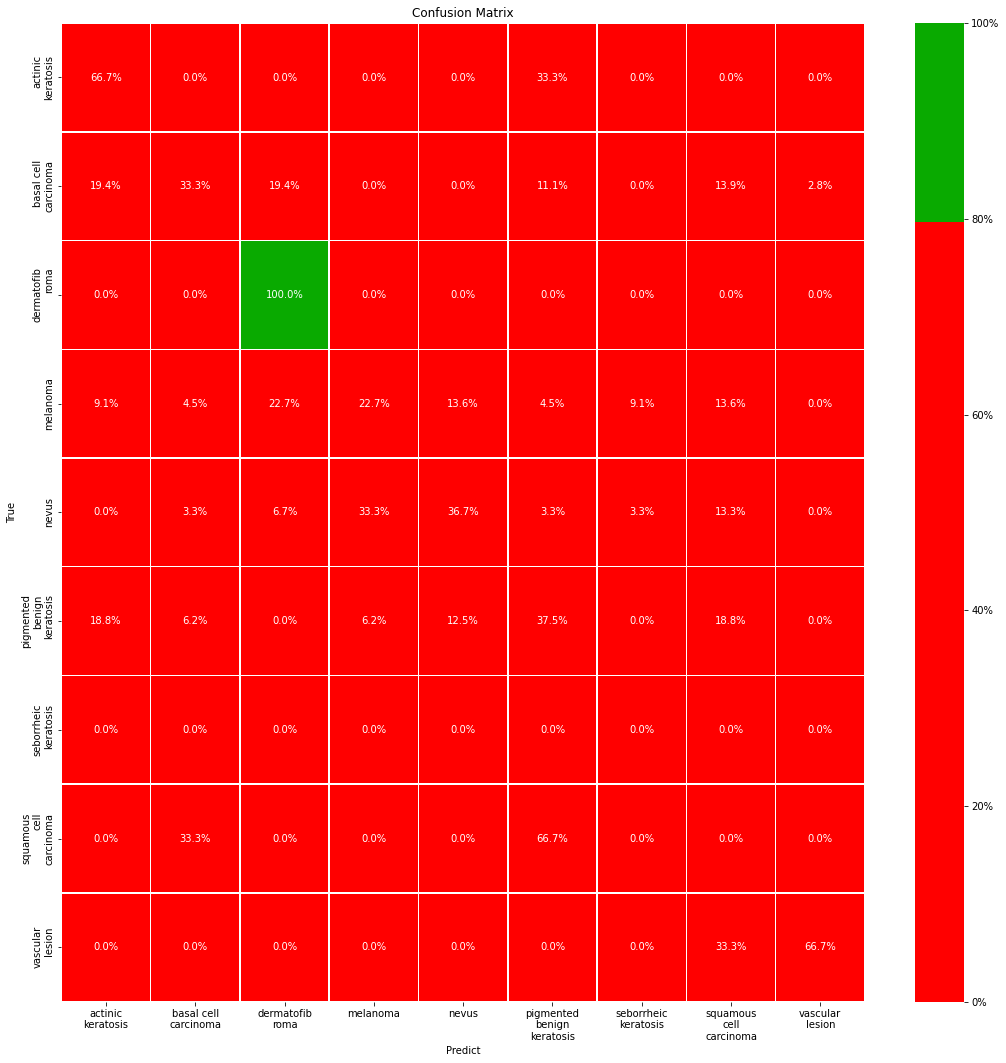

In [58]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(18,18))
# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0000', '#09AA00'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage' 
               linecolor='white',
               ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])